# Simulación de un Sistema de Colas 🕒

Este proyecto implementa una **simulación de un sistema de colas** basada en el enfoque introducido en el artículo _Introduction to Simulation Theory_ de **Banks**. La simulación consta de varios componentes clave: clientes, servidores y la propia lógica de la simulación. Aquí, se modelan varios clientes que llegan a un sistema donde un conjunto de servidores atienden sus solicitudes. Cada cliente tiene un tiempo de llegada y un tiempo de servicio, y los servidores pueden estar ocupados o libres.

La simulación permite estudiar el comportamiento de este sistema, generando métricas como:
- El tiempo en la **cola** ⏳,
- El **tiempo total en el sistema** ⏲️, 
- La **utilización de los servidores** 🖥️.

Esto permite evaluar el rendimiento del sistema de colas, obteniendo información sobre el flujo de clientes, la eficiencia de los servidores y las características del sistema bajo diferentes distribuciones de tiempo de llegada y servicio.

---


In [9]:
from random import seed
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional

## Clase Cliente 👥

La clase `Client` modela el comportamiento de un cliente dentro del sistema. Cada cliente tiene:
- Un **ID** que lo identifica de forma única.
- Un **tiempo de llegada** que se genera utilizando una distribución probabilística.
- Un **tiempo de servicio** que representa cuánto tiempo requiere para ser atendido por un servidor.

### Atributos Principales:
- **`id`**: Identificador único del cliente.
- **`arrival_time`**: El tiempo en que el cliente llega al sistema.
- **`service_time`**: Tiempo necesario para que el servidor atienda al cliente.
- **`time_in_queue`**: Tiempo que el cliente espera en la cola antes de ser atendido.
- **`time_in_system`**: Tiempo total que el cliente pasa en el sistema (incluye tiempo de espera y de servicio).

> _El comportamiento de los clientes está determinado por distribuciones estadísticas que pueden ser ajustadas para representar diferentes escenarios reales._

---



In [3]:
class Client:
    @staticmethod
    def generate_clients(num_clients=10, arrival_dist=None, service_dist=None):
        """
        Generate a list of clients with specified arrival and service time distributions.
        """
        clients = []
        arrival_time = 0
        for i in range(1, num_clients + 1):
            if arrival_dist is not None:
                inter_arrival = max(1, int(arrival_dist()))  # Ensure at least 1 time unit between arrivals
                arrival_time += inter_arrival
            if service_dist is not None:
                service_time = max(1, int(service_dist()))  # Ensure service time is at least 1
            else:
                service_time = np.random.randint(1, 10)
            clients.append(Client(i, arrival_time, service_time))
        return clients

    def __init__(self, id: int, arrival_time: int, service_time: int):
        self.id = id
        self.arrival_time = arrival_time
        self.service_time = service_time
        self.original_service_time = service_time
        
        self.time_in_system = 0
        self.time_in_queue = 0
        self.time_service_begins = 0
        self.time_service_end = 0
        self.server = None

    def __str__(self):
        return (f'Client {self.id} arrived at {self.arrival_time}, '
                f'service time {self.original_service_time} minutes. '
                f'Queue time {self.time_in_queue}, system time {self.time_in_system}. '
                f'Service on server {self.server.id if self.server else "None"}')

## Clase Servidor 🖥️

La clase `Server` representa un servidor que atiende a los clientes. El servidor tiene dos estados: _ocupado_ o _disponible_. Cuando un servidor está libre, asigna a un cliente que llega o que está en la cola.

### Atributos Principales:
- **`id`**: Identificador del servidor.
- **`is_busy`**: Indica si el servidor está ocupado atendiendo a un cliente.
- **`current_client`**: Referencia al cliente actual que está siendo atendido.
- **`attended_clients`**: Lista de los clientes que han sido atendidos por el servidor.

### Funcionalidades:
- **`assign_client`**: Asigna un cliente al servidor si está disponible.
- **`release_client`**: Libera al cliente cuando se completa su servicio.

> _Los servidores se encargan de procesar las solicitudes de los clientes. Una vez que un servidor está libre, puede asignarse a otro cliente en la cola o esperar por nuevas llegadas._

---


In [10]:
class Server:
    @staticmethod
    def generate_servers(num: int = 2):
        """
        Generate a list of servers.
        """
        return [Server(idx + 1) for idx in range(num)]

    def __init__(self, id: int):
        self.id = id
        self.is_busy = False
        self.current_client:Optional[Client] = None
        self.attended_clients:list = []

    def assign_client(self, client: Client, current_time: int):
        """
        Assign a client to this server.
        """
        self.current_client = client
        self.is_busy = True
        client.server = self
        client.time_service_begins = current_time
        client.time_in_queue = current_time - client.arrival_time

    def release_client(self, current_time: int):
        """
        Release the current client from this server.
        """
        if self.current_client is not None:
            self.current_client.time_service_end = current_time
            self.current_client.time_in_system = self.current_client.time_service_end - self.current_client.arrival_time
        self.attended_clients.append(self.current_client)
        self.is_busy = False
        self.current_client = None

## Clase Simulación 🚦

La clase `Simulation` gestiona el comportamiento global del sistema de colas. Esta clase orquesta las interacciones entre clientes y servidores, y simula la llegada, la espera y el servicio de los clientes.

### Atributos Principales:
- **`clients`**: Lista de clientes en el sistema.
- **`servers`**: Lista de servidores disponibles.
- **`waiting_queue`**: Cola de espera para los clientes que no pueden ser atendidos inmediatamente.
- **`current_time`**: Mantiene el tiempo actual de la simulación.

### Métodos Principales:
- **`run`**: Ejecuta la simulación, asignando clientes a los servidores y manejando la cola de espera. Este método simula el tiempo y procesa el comportamiento dinámico del sistema.
- **`plot_metrics`**: Genera gráficos que muestran el rendimiento del sistema, como la longitud de la cola en el tiempo, el tiempo total en el sistema y la utilización de los servidores.

> _La clase simulación organiza el flujo de eventos en el tiempo, las interacciones entre clientes y servidores, y el análisis de los resultados mediante gráficos._

---


In [5]:
class Simulation:
    def __init__(self, clients: list[Client], servers: list[Server]):
        self.current_time = 0
        self.servers = servers
        # Sort clients by arrival time
        self.clients = sorted(clients, key=lambda x: x.arrival_time)
        self.waiting_queue = []  # Separate waiting queue
        self.queue_lengths = []
        self.times = []

    def run(self):
        """
        Run the simulation until all clients are processed.
        """
        while self.clients or self.waiting_queue or any(server.is_busy for server in self.servers):
            # Assign arriving clients to servers or queue
            while self.clients and self.clients[0].arrival_time <= self.current_time:
                client = self.clients.pop(0)
                # Find a free server
                free_server = next((s for s in self.servers if not s.is_busy), None)
                if free_server:
                    free_server.assign_client(client, self.current_time)
                else:
                    self.waiting_queue.append(client)

            # Serve clients
            for server in self.servers:
                if server.is_busy:
                    server.current_client.service_time -= 1
                    if server.current_client.service_time <= 0:
                        server.release_client(self.current_time)

            # Assign waiting queue to free servers
            while self.waiting_queue and any(not s.is_busy for s in self.servers):
                free_server = next((s for s in self.servers if not s.is_busy), None)
                if free_server:
                    client = self.waiting_queue.pop(0)
                    free_server.assign_client(client, self.current_time)
                else:
                    break

            # Track queue length for plotting
            queue_length = len(self.waiting_queue)
            self.queue_lengths.append(queue_length)
            self.times.append(self.current_time)

            self.current_time += 1

            # Optional: Remove the safeguard if the simulation completes correctly
            if self.current_time > 10000:
                print("Simulation exceeded time limit. Stopping.")
                break

    def plot(self):
        """
        Print details of each attended client.
        """
        print("\n--- Simulation Results ---")
        for client in sorted([client for server in self.servers for client in server.attended_clients], key=lambda x: x.id):
            print(client)

    def plot_metrics(self):
        """
        Plot additional metrics for system performance: queue length, system time per client, 
        waiting time distribution, server utilization, service time distribution, and time in queue vs system.
        """
        plt.figure(figsize=(16, 12))
        
        # Plot queue length over time
        plt.subplot(2, 3, 1)
        plt.plot(self.times, self.queue_lengths, label='Queue Length', color='blue')
        plt.xlabel('Time')
        plt.ylabel('Number of Clients in Queue')
        plt.title('Queue Length Over Time')
        plt.grid(True)
        plt.legend()
        
        # Plot system time per client
        plt.subplot(2, 3, 2)
        clients = sorted([client for server in self.servers for client in server.attended_clients], key=lambda x: x.id)
        client_ids = [client.id for client in clients]
        system_times = [client.time_in_system for client in clients]

        plt.bar(client_ids, system_times, color='green')
        plt.xlabel('Client')  # Updated to say "Client"
        plt.ylabel('Time in System')
        plt.title('Client System Time')
        plt.xticks(client_ids)  # Ensure that only integer client IDs are shown
        plt.grid(True)

        # Plot waiting time distribution
        waiting_times = [client.time_in_queue for client in clients]
        plt.subplot(2, 3, 3)
        plt.hist(waiting_times, bins=10, color='orange', edgecolor='black')
        plt.xlabel('Time in Queue')
        plt.ylabel('Number of Clients')
        plt.title('Waiting Time Distribution')
        plt.grid(True)

        # Plot server utilization
        server_utilization = [sum(client.time_in_system for client in server.attended_clients) / self.current_time for server in self.servers]
        server_ids = [server.id for server in self.servers]
        plt.subplot(2, 3, 4)
        plt.bar(server_ids, server_utilization, color='purple')
        plt.xlabel('Server')
        plt.ylabel('Utilization (%)')
        plt.title('Server Utilization')
        plt.grid(True)

        # Plot service time distribution
        service_times = [client.original_service_time for client in clients]
        plt.subplot(2, 3, 5)
        plt.hist(service_times, bins=10, color='red', edgecolor='black')
        plt.xlabel('Service Time')
        plt.ylabel('Number of Clients')
        plt.title('Service Time Distribution')
        plt.grid(True)

        # Plot time in queue vs time in system
        plt.subplot(2, 3, 6)
        plt.scatter(waiting_times, system_times, color='brown')
        plt.xlabel('Time in Queue')
        plt.ylabel('Time in System')
        plt.title('Time in Queue vs Time in System')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

## Entry Point 🚀

El _entry point_ es la sección donde se inicializa y ejecuta la simulación. Aquí se definen las distribuciones para los tiempos de llegada y servicio, se generan los clientes y los servidores, y se ejecuta la simulación.

### Funcionalidades Principales:
- **Definición de distribuciones**: Se usan distribuciones estadísticas (exponencial, normal, etc.) para simular tiempos de llegada y servicio realistas.
- **Generación de clientes y servidores**: Se crean clientes y servidores utilizando las clases previamente definidas.
  
> _Este bloque es la "puerta de entrada" 🚪 para la simulación. Define las distribuciones, genera las entidades del sistema y finalmente ejecuta el ciclo de simulación, presentando los resultados en forma de gráficos y datos._ 

---



--- Simulation Results ---
Client 1 arrived at 1, service time 2 minutes. Queue time 0, system time 1. Service on server 1
Client 2 arrived at 2, service time 4 minutes. Queue time 0, system time 3. Service on server 2
Client 3 arrived at 3, service time 4 minutes. Queue time 0, system time 3. Service on server 1
Client 4 arrived at 5, service time 5 minutes. Queue time 0, system time 5. Service on server 2
Client 5 arrived at 6, service time 3 minutes. Queue time 0, system time 3. Service on server 1
Client 6 arrived at 7, service time 3 minutes. Queue time 2, system time 5. Service on server 1
Client 7 arrived at 8, service time 1 minutes. Queue time 2, system time 3. Service on server 2
Client 8 arrived at 9, service time 5 minutes. Queue time 2, system time 7. Service on server 2
Client 9 arrived at 10, service time 3 minutes. Queue time 2, system time 5. Service on server 1
Client 10 arrived at 11, service time 2 minutes. Queue time 4, system time 6. Service on server 1
Client 11

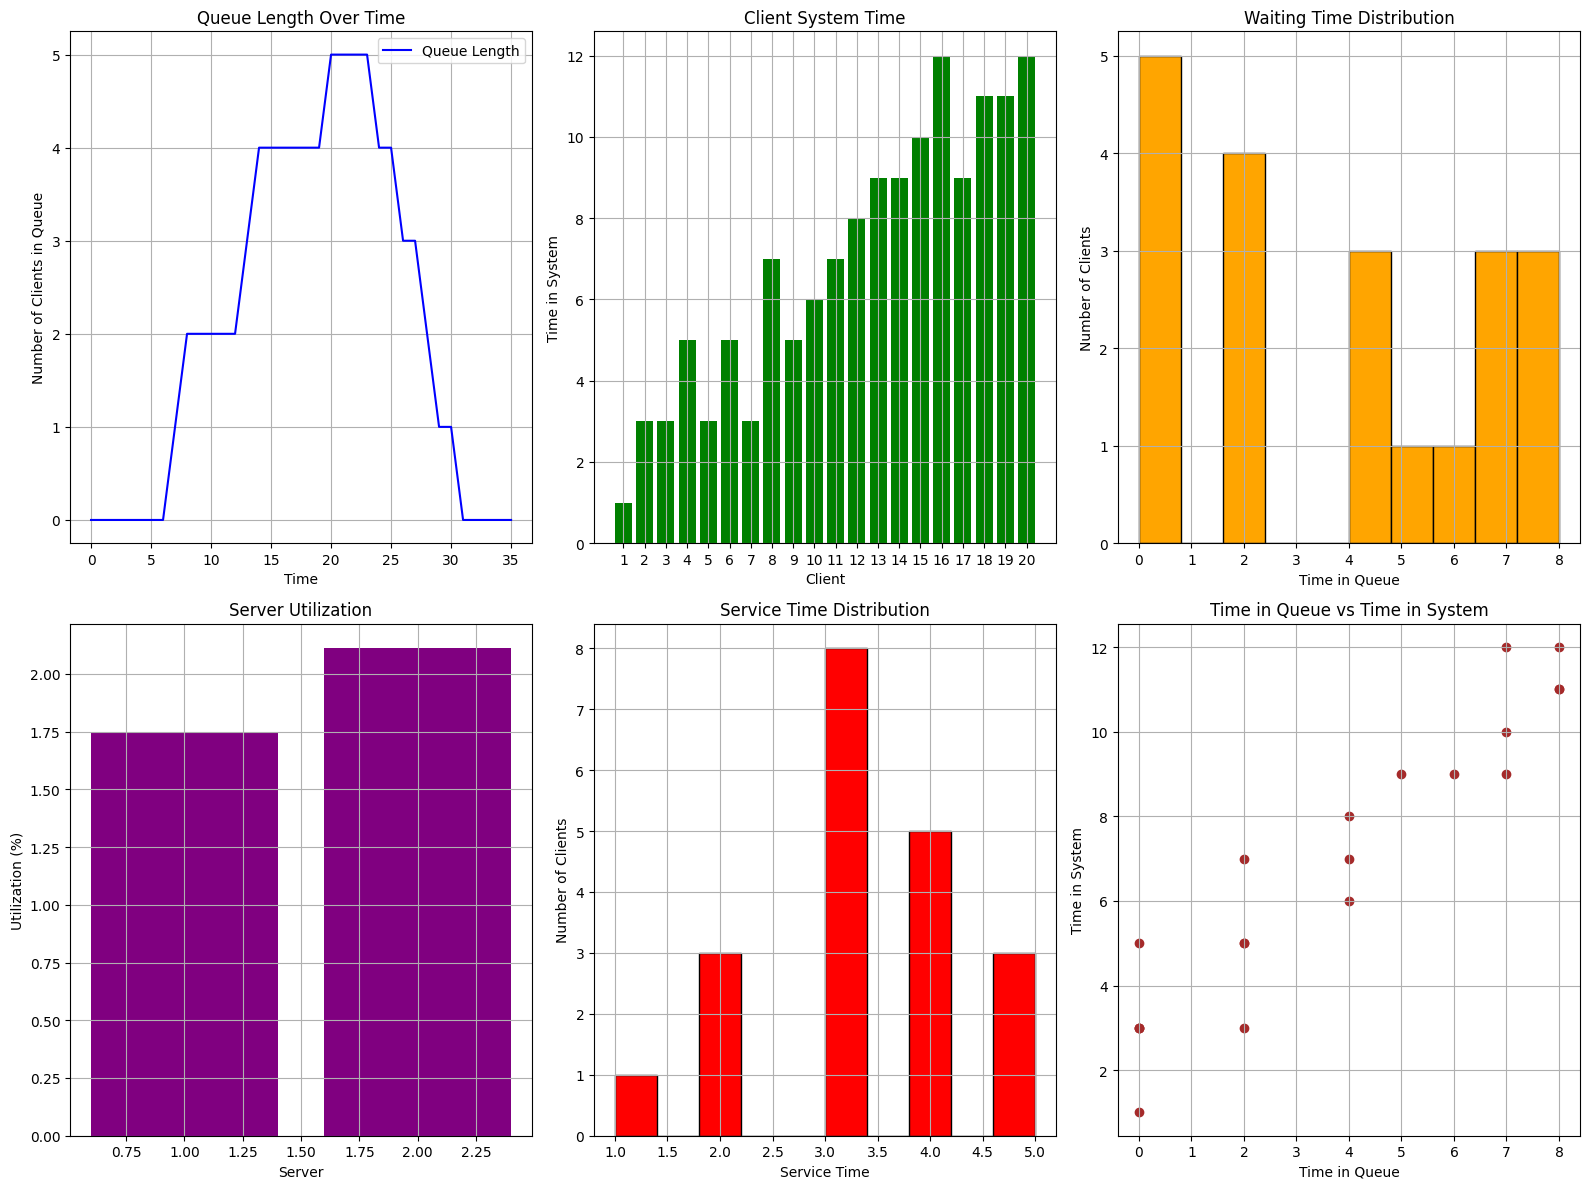

In [6]:

seed(42)
np.random.seed(42)
    
#!Define probability distributions for arrival and service times
    
service_dist = lambda: max(1, np.random.normal(loc=4, scale=1.5))  # Normal distribution for service time, mean=4, std=1.5
arrival_dist = lambda: np.random.exponential(scale=2)  # Mean inter-arrival time of 2
    
# Generate clients and servers
clients = Client.generate_clients(num_clients=20, arrival_dist=arrival_dist, service_dist=service_dist)
servers = Server.generate_servers(2)
    
    # Run simulation
sim = Simulation(clients=clients, servers=servers)
sim.run()
sim.plot()
sim.plot_metrics()



## 📊 Gráficos y Métricas de la Simulación

La simulación genera varios gráficos clave que muestran el rendimiento del sistema. Cada uno de estos gráficos proporciona información valiosa sobre diferentes aspectos del sistema:

### 1. **📈 Longitud de la Cola a lo Largo del Tiempo**
   - **Descripción**: Este gráfico muestra cómo cambia el número de clientes en la cola a lo largo del tiempo.
   - **Interpretación**: El eje *x* representa el tiempo de simulación, mientras que el eje *y* representa el número de clientes esperando en la cola. Los picos en la gráfica indican momentos en que el sistema experimentó mayor carga, mientras que los valles sugieren tiempos de menor tráfico o procesamiento eficiente de clientes.

### 2. **⏱️ Tiempo en el Sistema por Cliente**
   - **Descripción**: Este gráfico de barras muestra el tiempo total que cada cliente pasó en el sistema (desde su llegada hasta su salida).
   - **Interpretación**: Cada barra corresponde a un cliente específico, con el eje *x* representando los IDs de los clientes y el eje *y* mostrando el tiempo que cada cliente pasó en el sistema. Las barras más largas indican que los clientes experimentaron tiempos de espera prolongados o tiempos de servicio más largos.

### 3. **⌛ Distribución del Tiempo de Espera**
   - **Descripción**: Este histograma ilustra la distribución de los tiempos de espera (es decir, el tiempo que los clientes pasaron en la cola).
   - **Interpretación**: El eje *x* representa los diferentes tiempos de espera, y el eje *y* muestra el número de clientes que experimentaron esos tiempos. Una concentración de barras cerca del cero indica que muchos clientes tuvieron tiempos de espera mínimos, mientras que las barras más alejadas a la derecha reflejan clientes que esperaron más.

### 4. **🖥️ Utilización de los Servidores**
   - **Descripción**: Este gráfico de barras muestra la utilización de cada servidor durante la simulación.
   - **Interpretación**: Cada barra representa un servidor, con el eje *x* mostrando los IDs de los servidores y el eje *y* representando el porcentaje de tiempo que el servidor estuvo ocupado. Una mayor utilización indica que el servidor estuvo frecuentemente ocupado, mientras que una utilización más baja sugiere tiempos ociosos.

### 5. **🔧 Distribución del Tiempo de Servicio**
   - **Descripción**: Este histograma muestra la distribución de los tiempos de servicio para los clientes.
   - **Interpretación**: El eje *x* representa los diferentes tiempos de servicio, mientras que el eje *y* muestra la cantidad de clientes que recibieron servicios de esa duración. Este gráfico ayuda a comprender la variabilidad en la duración del servicio, con una concentración de barras alrededor del tiempo medio de servicio.

### 6. **📊 Tiempo en la Cola vs Tiempo en el Sistema**
   - **Descripción**: Este gráfico de dispersión muestra la relación entre el tiempo que los clientes pasaron esperando en la cola y su tiempo total en el sistema.
   - **Interpretación**: El eje *x* representa el tiempo en la cola, mientras que el eje *y* muestra el tiempo total en el sistema. Cada punto corresponde a un cliente. Si la mayoría de los puntos se encuentran cerca de la diagonal, sugiere que el tiempo en la cola es un contribuyente significativo al tiempo total en el sistema. Los puntos más alejados de la diagonal indican clientes con tiempos de servicio relativamente más cortos o más largos en comparación con su tiempo de espera.

---

## 📊 Analisis de los Gráficos y Métricas de la Simulación

Generemos una iteracíon con **100** clientes para analizar los gráficos y métricas de la simulación.


--- Simulation Results ---
Client 1 arrived at 1, service time 2 minutes. Queue time 0, system time 1. Service on server 1
Client 2 arrived at 2, service time 4 minutes. Queue time 0, system time 3. Service on server 2
Client 3 arrived at 3, service time 4 minutes. Queue time 0, system time 3. Service on server 1
Client 4 arrived at 5, service time 5 minutes. Queue time 0, system time 5. Service on server 2
Client 5 arrived at 6, service time 3 minutes. Queue time 0, system time 3. Service on server 1
Client 6 arrived at 7, service time 3 minutes. Queue time 2, system time 5. Service on server 1
Client 7 arrived at 8, service time 1 minutes. Queue time 2, system time 3. Service on server 2
Client 8 arrived at 9, service time 5 minutes. Queue time 2, system time 7. Service on server 2
Client 9 arrived at 10, service time 3 minutes. Queue time 2, system time 5. Service on server 1
Client 10 arrived at 11, service time 2 minutes. Queue time 4, system time 6. Service on server 1
Client 11

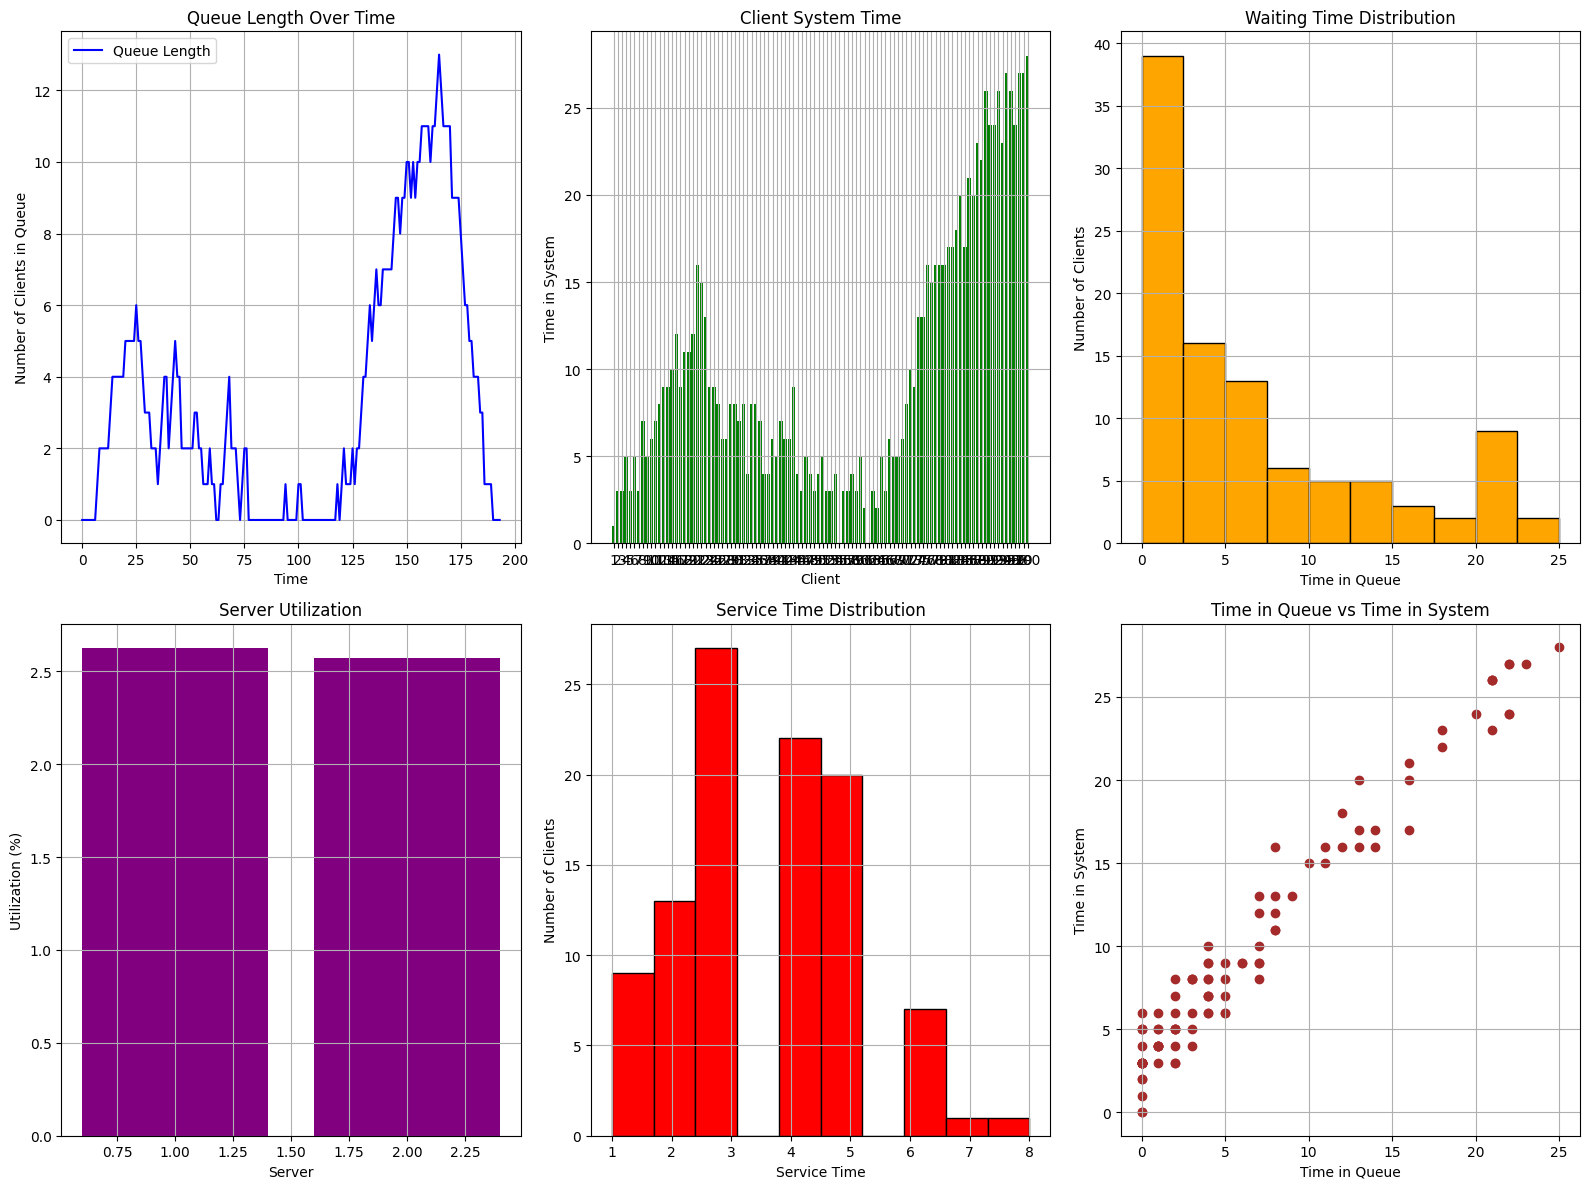

In [7]:

if __name__ == '__main__':
    seed(42)
    np.random.seed(42)
    service_dist = lambda: max(1, np.random.normal(loc=4, scale=1.5)) 
    arrival_dist = lambda: np.random.exponential(scale=2)  
    
    
    # Generate clients and servers
    clients = Client.generate_clients(num_clients=100, arrival_dist=arrival_dist, service_dist=service_dist)
    servers = Server.generate_servers(2)
    
    # Run simulation
    sim = Simulation(clients=clients, servers=servers)
    sim.run()
    sim.plot()
    sim.plot_metrics()

Podemos observar como existe una fuerte correlacion entre el grafico del tamaño de la cola y el tiempo total en el sistema, lo que indica que el tiempo en la cola es un factor determinante en el tiempo total que un cliente pasa en el sistema. Esto esta respaldado tambien por la nube de puntos del ultimo grafico donde notamos poca dispersion. Además, la distribución del tiempo de espera muestra que la mayoría de los clientes esperan un tiempo relativamente corto, pero algunos clientes experimentan tiempos de espera más largos. La utilización de los servidores se denota pareja y cargada por lo que podemos identificar que ambos servidores estan siendo utilizados a una capacidad razonable. La distribución del tiempo de servicio se condice con los parametros utilizados para la generacion de la  distribucion normal  de donde se tomaron las muestras.

Ahora probemos aumentando el numero de servidores  a **5** y cambiando la media de la distribucion de los tiempos de servicio a **5**.


--- Simulation Results ---
Client 1 arrived at 1, service time 3 minutes. Queue time 0, system time 2. Service on server 1
Client 2 arrived at 2, service time 5 minutes. Queue time 0, system time 4. Service on server 2
Client 3 arrived at 3, service time 5 minutes. Queue time 0, system time 4. Service on server 3
Client 4 arrived at 5, service time 6 minutes. Queue time 0, system time 5. Service on server 1
Client 5 arrived at 6, service time 4 minutes. Queue time 0, system time 3. Service on server 4
Client 6 arrived at 7, service time 4 minutes. Queue time 0, system time 3. Service on server 2
Client 7 arrived at 8, service time 1 minutes. Queue time 0, system time 0. Service on server 3
Client 8 arrived at 9, service time 6 minutes. Queue time 0, system time 5. Service on server 3
Client 9 arrived at 10, service time 4 minutes. Queue time 0, system time 3. Service on server 4
Client 10 arrived at 11, service time 3 minutes. Queue time 0, system time 2. Service on server 1
Client 11

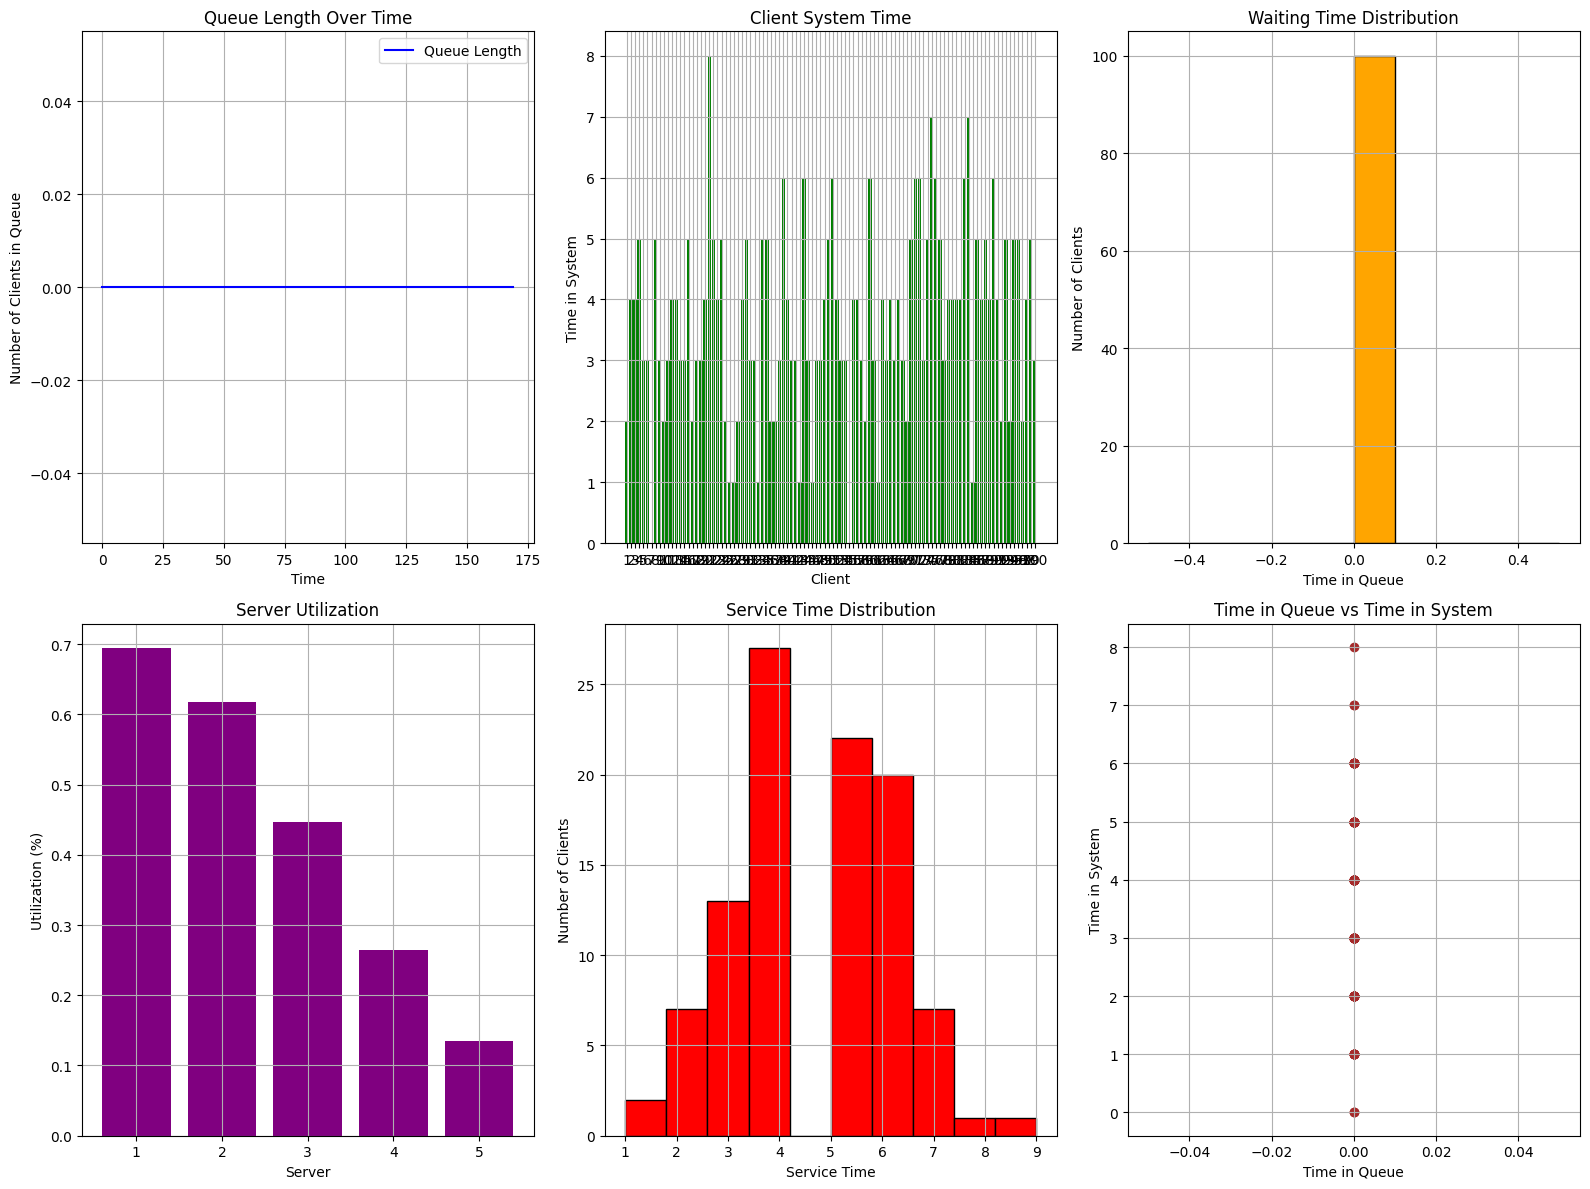

In [8]:

if __name__ == '__main__':
    seed(42)
    np.random.seed(42)
    service_dist = lambda: max(1, np.random.normal(loc=5, scale=1.5)) 
    arrival_dist = lambda: np.random.exponential(scale=2)
    
    # Generate clients and servers
    clients = Client.generate_clients(num_clients=100, arrival_dist=arrival_dist, service_dist=service_dist)
    servers = Server.generate_servers(5)
    
    # Run simulation
    sim = Simulation(clients=clients, servers=servers)
    sim.run()
    sim.plot()
    sim.plot_metrics()

Podemos identificar rapidamente que la correlacion entre el tamano de la cola y el tiempo de cada client en el sistema se perdio totalmente.Gracias al aumento de servidores, la cola nunca permanece llena y los clientes son atendidos rapidamente. La distribucion del tiempo de espera muestra que la mayoria de los clientes esperan un tiempo muy corto (cercano a 0). Podemos observar tambien que el 5 servidor muestra una utilizacion casi nula respecto de sus pares. Por lo que podriamos decir que invertir en 5 servidores, para este sistema en especifico, no seria razonable ya que no tendra un impacto significativo en el tiempo total que un cliente pasa en el sistema.